# 實價登錄房價分析
- [做的資料是哪個區域?](#scrollTo=xnFUMEwtwXTz)
- [資料共多少筆?](#scrollTo=p-PliTTOwlV8)
- 資料如何取得?
  - [收集](#scrollTo=xnFUMEwtwXTz)
  - [萃取](#scrollTo=p-PliTTOwlV8)
- [Linear Regression Model](#scrollTo=DiPFO-eDw1X6)

## 部署環境

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [ ]:
import requests
import os
import time

import numpy as np
import pandas as pd
from tqdm import tqdm

import matplotlib.pyplot as plt

In [ ]:
os.chdir('/content/drive/MyDrive/ML/assignment_1/data') 

In [ ]:
loc = 'N'

## 下載資料
這裡我修改了原本那份房價分析的爬蟲腳本，原因是我們這次的任務只需要一個區域，原本的爬蟲腳本會下載多餘的資料使得空間占用太大，執行時效率也不佳，sleep time也縮短了，避免浪費等候的時間。

我使用的資料區域是**彰化縣**，時間從**102到109**共8年

In [ ]:
# Crawl data
# Better store in your GDrive, so don't need to re-do it every time
def real_estate_crawler(year, season, loc):
    if year > 1000:
        year -= 1911

    folder_name = f"{year}{season}_{loc}"

    if os.path.exists(folder_name):
      print(f'{folder_name} exists. skip.')
      return

    if not os.path.isdir(folder_name):
      os.mkdir(folder_name)

    # download real estate zip file
    for ver in {'A', 'B', 'C'}:
      fname = f'{loc}_lvr_land_{ver}.csv'
      res = requests.get(f"https://plvr.land.moi.gov.tw//DownloadSeason?season={year}S{season}&fileName={fname}")
      # save content to file
      open(os.path.join(folder_name, fname), 'wb').write(res.content)
      time.sleep(2)

for year in range(102, 110):
    for season in range(1,5):
        print('crawling', year, 'S', season)
        real_estate_crawler(year, season, loc)
        time.sleep(1)

crawling 102 S 1
1021_N exists. skip.
crawling 102 S 2
1022_N exists. skip.
crawling 102 S 3
1023_N exists. skip.
crawling 102 S 4
1024_N exists. skip.
crawling 103 S 1
1031_N exists. skip.
crawling 103 S 2
1032_N exists. skip.
crawling 103 S 3
1033_N exists. skip.
crawling 103 S 4
1034_N exists. skip.
crawling 104 S 1
1041_N exists. skip.
crawling 104 S 2
1042_N exists. skip.
crawling 104 S 3
1043_N exists. skip.
crawling 104 S 4
1044_N exists. skip.
crawling 105 S 1
1051_N exists. skip.
crawling 105 S 2
1052_N exists. skip.
crawling 105 S 3
1053_N exists. skip.
crawling 105 S 4
1054_N exists. skip.
crawling 106 S 1
1061_N exists. skip.
crawling 106 S 2
1062_N exists. skip.
crawling 106 S 3
1063_N exists. skip.
crawling 106 S 4
1064_N exists. skip.
crawling 107 S 1
1071_N exists. skip.
crawling 107 S 2
1072_N exists. skip.
crawling 107 S 3
1073_N exists. skip.
crawling 107 S 4
1074_N exists. skip.
crawling 108 S 1
1081_N exists. skip.
crawling 108 S 2
1082_N exists. skip.
crawling 108

In [ ]:
# 合併資料
dirs = [d for d in os.listdir()]

dfs = []

for d in dirs:
    df = pd.read_csv(os.path.join(d, f'{loc}_lvr_land_A.csv'), index_col=False)
    df['season'] = d[-3]
    dfs.append(df.iloc[1:])
    
df = pd.concat(dfs, sort=True)
df.head()

,season,主建物面積,主要建材,主要用途,交易年月日,交易標的,交易筆棟數,備註,單價元平方公尺,土地位置建物門牌,土地移轉總面積平方公尺,建物型態,建物現況格局-廳,建物現況格局-房,建物現況格局-衛,建物現況格局-隔間,建物移轉總面積平方公尺,建築完成年月,有無管理組織,移轉層次,移轉編號,編號,總價元,總樓層數,車位移轉總面積(平方公尺),車位總價元,車位類別,都市土地使用分區,鄉鎮市區,附屬建物面積,陽台面積,電梯,非都市土地使用分區,非都市土地使用編定
1,1,88.56,加強磚造,住家用,1050930,房地(土地+建物),土地4建物1車位0,NaN,40650,彰化縣彰化市國聖路95巷4號,94.37,透天厝,2,2,2,有,88.56,0700204,無,全,NaN,RPUNMLNJJILFFAN58CA,3600000,二層,0.0,0,NaN,NaN,彰化市,0.00,0.0,NaN,特定農業區,甲種建築用地
2,1,106.20,鋼筋混凝土加強磚造,住商用,1051010,房地(土地+建物),土地1建物1車位0,NaN,80038,彰化縣彰化市辭修北路198巷18號,80.0,透天厝,3,5,3,有,106.2,0680911,無,全,NaN,RPVNMLNJJILFFAN68CA,8500000,二層,0.0,0,NaN,住,彰化市,0.00,0.0,NaN,NaN,NaN
3,1,87.06,鋼筋混凝土加強磚造,住家用,1050926,房地(土地+建物),土地1建物1車位0,NaN,68918,彰化縣彰化市茄南街７０巷２７號,80.0,透天厝,2,3,2,有,87.06,0680312,無,全,NaN,RPOOMLNJJILFFAN08CA,6000000,二層,0.0,0,NaN,住,彰化市,0.00,0.0,NaN,NaN,NaN
4,1,2054.03,見其他登記事項,見其他登記事項,1051011,房地(土地+建物),土地1建物2車位0,NaN,19183,彰化縣彰化市林森西路１０６號,2068.21,透天厝,3,6,3,有,2085.18,0760711,無,全,NaN,RPQOMLNJJILFFAN28CA,40000000,二層,0.0,0,NaN,農,彰化市,31.15,0.0,NaN,NaN,NaN
5,1,0.00,NaN,NaN,1051020,土地,土地1建物0車位0,NaN,7059,莿桐段1889地號,1700.0,其他,0,0,0,有,0.0,NaN,無,NaN,NaN,RPVOMLNJJILFFAN78CA,12000000,NaN,0.0,0,NaN,農,彰化市,0.00,0.0,NaN,NaN,NaN


## 資料前處理
由於這次任務的資料特徵只有土地面積，因此這邊只選住家用、且交易含土地的資料，以確保土地交易面積能成為一項足夠明顯的特徵。

另外擁有備註的交易資料也會移除，原因跟原本房價分析所說的一樣。

處理完後的資料共**17232筆**。

In [ ]:
# extract
df = df[df['備註'].isnull()]
_filter = (df['主要用途'] == '住家用') & (df['交易標的'].str.contains('土地'))
_df = df[_filter][['土地移轉總面積平方公尺', '總價元']].astype(float)
_df.columns = ['size', 'price']
_df.sort_values('size', inplace=True)
_df.head()

,size,price
2694,0.00,6500000.0
16,1.07,2795000.0
1579,2.57,600000.0
1888,2.59,1230000.0
1779,2.68,61000.0


In [ ]:
# 共有17232筆資料
len(_df)

17232

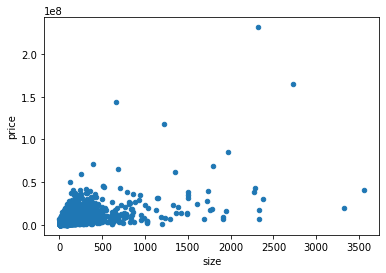

In [ ]:
# 檢查資料分布
_df.plot(x='size', y='price', kind='scatter')

## Linear Regression

In [ ]:
def standardize(data: np.array):
  mean = data.mean()
  std = data.std()
  
  return np.array([(x-mean)/std for x in data])

def min_max_scale(data: np.array):
  mean = data.mean()
  diff = data.max() - data.min()
  
  return np.array([(x - mean)/diff for x in data])

def fit_LR(x, y, epochs=10000, lr=0.001):
  x = x.reshape(len(x), 1)
  y = y.reshape(len(y), 1)

  theta = np.random.randn(2, 1)
  xx = np.hstack((np.ones((len(x),1)), x))

  for epoch in tqdm(range(epochs)):
    prediction = np.dot(xx, theta)

    # prediction_error
    pred_error = y - prediction
    mse = (pred_error ** 2).mean()
    if(np.isnan(mse)):
      print(epoch)

    gradients = np.dot(xx.T, pred_error) / len(x)
    
    # update the parameters
    theta += lr * gradients
    plt.plot(epoch, mse, 'o-', color='red')

  plt.xlabel('epoch', fontsize=16)
  plt.ylabel('mse', fontsize=16)
  plt.xticks(np.arange(0, epochs, step=epochs//5))
  plt.show()

  return {'loss': mse, 'theta': theta}

In [ ]:
x = _df['size'].to_numpy()
y = _df['price'].to_numpy()

### Z-Score Scaler
Since the data range is too huge, we use **Z-Score Standardization**
to scale them so that they follow the standard normal distribution.

Here we don't concern about how to reverse them to the origin data
since it can be simply done by multiply $\sigma$ and plus $\mu$ on
each point.

100%|██████████| 10000/10000 [00:15<00:00, 659.23it/s]


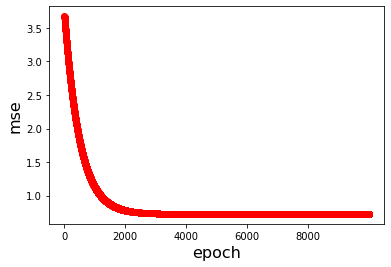

In [ ]:
# test Z-Score Scaler
xx = standardize(x)
yy = standardize(y)
result = fit_LR(xx, yy, lr=0.001)

MSE: 0.7274181962387631
Theta_0: [-6.48851095e-05]
Theta_1: [0.5221361]


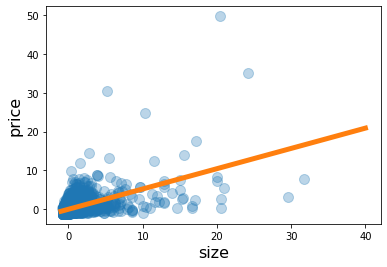

In [ ]:
theta = result["theta"]
print(f'MSE: {result["loss"]}')
print(f'Theta_0: {theta[0]}')
print(f'Theta_1: {theta[1]}')

x_axis = np.linspace(-1, 40)
reg = theta[0] + theta[1] * x_axis
plt.plot(xx, yy, 'o', markersize=10, alpha=0.3)
plt.plot(x_axis, reg, linewidth=5)
plt.xlabel('size', fontsize=16)
plt.ylabel('price', fontsize=16)
plt.show()

### Min-Max Scaler
Since the data range is too huge, we use **Min-Max Normalization**
to scale them so that they are all in $[-1, 1]$ with $\mu$ close to zero.

Here we don't concern about how to reverse them to the origin data
since it can be simply done by multiply `max-min` and plus $\mu$ on
each point.

100%|██████████| 10000/10000 [00:15<00:00, 651.72it/s]


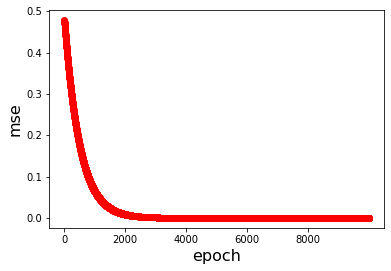

In [ ]:
# test Min-Max Scaler
xx = min_max_scale(x)
yy = min_max_scale(y)
result = fit_LR(xx, yy, lr=0.001)

MSE: 0.0003132769484501224
Theta_0: [3.12241334e-05]
Theta_1: [0.14836375]


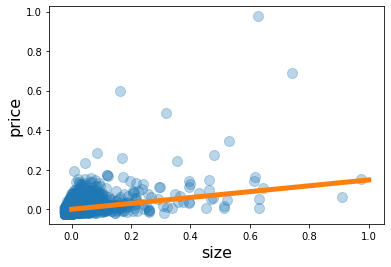

In [ ]:
theta = result["theta"]
print(f'MSE: {result["loss"]}')
print(f'Theta_0: {theta[0]}')
print(f'Theta_1: {theta[1]}')

x_axis = np.linspace(0, 1)
reg = theta[0] + theta[1] * x_axis
plt.plot(xx, yy, 'o', markersize=10, alpha=0.3)
plt.plot(x_axis, reg, linewidth=5)
plt.xlabel('size', fontsize=16)
plt.ylabel('price', fontsize=16)
plt.show()